In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Import scoring functions

In [2]:
# Code from Lars Grönberg
def binaryScore(y: pd.Series, y_pred: pd.Series, normalize :bool = False) -> float:
    """Calculates the score according to the DMC22 evalution rules for a binary prediction and response

    Args:
        y (pd.Series): true y_
        y_pred (pd.Series): predicted y
        normalize (bool): normalizes the score to a value in [0,1]. Defaults to false.

    Raises:
        ValueError: If number of unique classes in y or y_pred is different from 2

    Returns:
        int: Score according to the DMC22 evaluation if normalize is false.
        float: Score according to the DMC22 evaluation if normalize is true.
    
    Examples:
        >>> truey = pd.Series([0,1,0,1])
        >>> predy = pd.Series([1,0,1,1])
        >>> binaryScore(truey,predy)
        1.5

        >>> truey = pd.Series([0,1,0,1])
        >>> predy = pd.Series([1,0,1,1])
        >>> binaryScore(truey,predy, normalize=True)
        0.3

        >>> truey = pd.Series([1,1,0,1])
        >>> predy = pd.Series([1,1,0,1])
        >>> binaryScore(truey,predy)
        5.5

        >>> truey = pd.Series([1,1,0,1])
        >>> predy = pd.Series([1,1,0,1])
        >>> binaryScore(truey,predy,normalize=True)
        1  
    """
    if (y.astype(int).apply(lambda x: x in [0,1]).all() == False) or (y_pred.astype(int).apply(lambda x: x in [0,1]).all() == False) :
        raise ValueError('y and y_pred are only allowed to contain the elements 0 or 1')

    rightPrediction = np.abs(y-y_pred) == 0
    index0 = (y==0)
    score = np.sum((rightPrediction&index0)*1 + (rightPrediction & ~index0)*1.5)

    if normalize == True:
        maxScore =  np.sum(index0*1 + ~index0*1.5)
        return(score/maxScore)
    else:
        return(score)

def multiclassScore(y: pd.Series, y_pred: pd.Series,normalize :bool = False) -> float:
    """Calculates the score according to the DMC22 evalution rules for a multiclass prediction and response

    Args:
        y (pd.Series): true y
        y_pred (pd.Series): predicted y
        normalize (bool): normalizes the score to a value in [0,1]. Defaults to false.

    Returns:
        int: Score according to the DMC22 evaluation if normalize is false.
        float: Score according to the DMC22 evaluation if normalize is true.
    
    Example:
        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([4,4,0.0,0,0,3])
        >>> multiclassScore(ytrue,ypred)
        6

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([4,4,0.0,0,0,3])
        >>> multiclassScore(ytrue,ypred,normalize=True)
        0.375

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([3,4,0,1,4,2])
        >>> multiclassScore(ytrue,ypred)
        16

        >>> ytrue = pd.Series([3,4,0,1,4,2])
        >>> ypred = pd.Series([3,4,0,1,4,2])
        >>> multiclassScore(ytrue,ypred,normalize=True)
        1.0

    """

    if (y.astype(int).apply(lambda x: x in [0,1,2,3,4]).all() == False) or (y_pred.astype(int).apply(lambda x: x in [0,1,2,3,4]).all() == False) :
        raise ValueError('y and y_pred are only allowed to contain the elements 0,1,2,3,4')


    behaviourY = np.where(y>0,1,0) #1 is buying
    behaviourPredY = np.where(y_pred>0,1,0)
    correctBehaviour = np.sum(behaviourY == behaviourPredY)

    correctPredictionsWeek = np.sum((y == y_pred) & (y > 0))

    score = (correctBehaviour-correctPredictionsWeek)*1+correctPredictionsWeek*3

    if normalize == True:
        maxScore = np.sum((y>0)*3 + (y==0)*1)
        return(score/maxScore)
    else:
        return(score)


### Import dataset

In [3]:
binary_train = pd.read_csv('binary_train_70_backgroundTrainTestsplit.csv')
binary_test = pd.read_csv('binary_test_30_backgroundTrainTestsplit.csv')

### Splitting train_set and test_set into X_train, y_train, X_test, y_test

In [4]:
X_train = binary_train.drop(columns=['item_bought_next_28_days'])
y_train = binary_train['item_bought_next_28_days']

X_test = binary_test.drop(columns = ['item_bought_next_28_days'])
y_test = binary_test['item_bought_next_28_days']

In [5]:
X_train

,userID,itemID
0,1199,637
1,21557,3520
2,23387,1633
3,32069,29311
4,30359,11124
...,...,...
64238,40754,7997
64239,37518,18630
64240,27676,3997
64241,42405,28532


### Merging X_train, X_test with features

In [7]:
features = pd.read_csv('3_IU_FEAT_Average_Day.csv', index_col = 0).drop(columns=['first_date_bought', 'last_date_bought'])
features

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,0,1505,0.0,93,93
1,0,6446,0.0,194,194
2,0,9325,0.0,173,173
3,0,12468,0.0,64,64
4,0,12505,0.0,79,79
...,...,...,...,...,...
919701,46137,2667,0.0,109,109
919702,46137,20209,0.0,69,69
919703,46137,28343,0.0,69,69
919704,46137,28900,0.0,69,69


In [9]:
X_train_feat = X_train.merge(features, how = 'inner', on = ['userID', 'itemID'])
X_test_feat = X_test.merge(features, how = 'inner', on = ['userID', 'itemID'])
X_train_feat

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,1199,637,126.0,14,140
1,21557,3520,83.0,72,155
2,23387,1633,124.0,31,155
3,32069,29311,28.0,135,191
4,30359,11124,10.0,119,129
...,...,...,...,...,...
64238,40754,7997,31.0,52,114
64239,37518,18630,65.5,80,211
64240,27676,3997,127.0,77,204
64241,42405,28532,115.0,34,149


In [10]:
X_test_feat

,userID,itemID,average_cycle_days,first_day_delta_bought,last_day_delta_bought
0,16831,32528,64.00,129,193
1,25813,12911,94.00,47,141
2,21519,16041,26.00,108,134
3,21214,6478,84.00,16,100
4,20386,19932,34.00,26,94
...,...,...,...,...,...
27529,2176,9773,42.00,138,180
27530,20041,19824,53.33,25,185
27531,39920,18714,159.00,23,182
27532,5127,1299,47.50,118,213


# Training Model
- using features: userID, itemID, average_cycle_days,first_day_delta_bought,last_day_delta_bought
- y is prediction column

### Feature scaling

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_feat = sc.fit_transform(X_train_feat)
X_test_feat = sc.transform(X_test_feat)

In [12]:
print(X_train_feat)

[[-1.64276069 -1.68334004  1.1869798  -1.02251965 -0.45332435]
 [-0.11693705 -1.37929404  0.16149324  0.25036148 -0.11276811]
 [ 0.02022069 -1.57830022  1.13928275 -0.6494338  -0.11276811]
 ...
 [ 0.34167946 -1.32898883  1.21082833  0.36009261  0.99971558]
 [ 1.44561189  1.25851328  0.92464603 -0.58359512 -0.24899061]
 [-1.34685973  0.50034932 -0.26778021  1.1940492   0.45482561]]


In [13]:
print(X_test_feat)

[[-0.47114879  1.67993812 -0.29162874  1.50129637  0.74997434]
 [ 0.20204838 -0.38890349  0.42382701 -0.29829418 -0.4306206 ]
 [-0.11978513 -0.05880846 -1.19787268  1.04042562 -0.58954684]
 ...
 [ 1.25936217  0.22309059  1.97398112 -0.82500361  0.50023311]
 [-1.34835872 -1.61352442 -0.6851294   1.25988788  1.20404932]
 [ 0.51398855 -0.54256114 -0.43471989  0.03089921 -0.90739932]]


# I. Random Forest Classification Model

### Training the Random Forest Classification model on the Training set

In [14]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_feat, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Predicting the test set result

In [1]:
y_pred = classifier.predict(X_test_feat)


NameError: name 'classifier' is not defined

### Making confusion matrix and calculating accuracy score

In [16]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
ac = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {ac}")

preci = precision_score(y_test, y_pred, average = None)
print(f"Precision score: {preci}")

recall = recall_score(y_test, y_pred, average = None)
print(f"Recall score: {recall}")

f1_sc = f1_score(y_test, y_pred, average = None)
print(f"f1 score: {f1_sc}")

Confusion matrix:
[[21769   850]
 [ 4222   693]]
Accuracy score: 0.8157913851964843
Precision score: [0.83755916 0.44912508]
Recall score: [0.96242097 0.14099695]
f1 score: [0.89565933 0.21461753]


### Applying binaryScore() function to calculate the score of the model
- if y_true = 1 and y_pred = 1  --> getting 1.5 score
- if y_true = 0 and y_pred = 0 --> getting 1 score
- Otherwise 0 score
--> In general, the final score tells us how many score has our model obtained with considering that the value of prediction 1_classifier correctly is higher than that of 0_classifier

In [17]:
# converting y_pred from type of numpy.ndarray to pd.Series in order to apply the binaryScore()
y_pred_conv = pd.Series(y_pred)
y_pred_conv

0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
27529    0.0
27530    1.0
27531    0.0
27532    0.0
27533    0.0
Length: 27534, dtype: float64

In [19]:
score = binaryScore(y_test, y_pred_conv, normalize= False)
score

22808.5

# II. Decision Tree Classification Model 

### Training the Decision Tree Classification model on the Training set

In [20]:
from sklearn.tree import DecisionTreeClassifier
cl_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
cl_tree.fit(X_train_feat, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

### Predicting the test set result

In [21]:
y_pred_tree = cl_tree.predict(X_test_feat)

### Making the confusion matrix

In [22]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
print('Confusion matrix:')
print(cm_tree)

ac_tree = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy score: {ac_tree}")

preci_tree = precision_score(y_test, y_pred_tree, average = None)
print(f"Precision score: {preci_tree}")

recall_tree = recall_score(y_test, y_pred_tree, average = None)
print(f"Recall score: {recall_tree}")

f1_sc_tree = f1_score(y_test, y_pred_tree, average = None)
print(f"f1 score: {f1_sc_tree}")

Confusion matrix:
[[18964  3655]
 [ 3495  1420]]
Accuracy score: 0.7403210576015109
Precision score: [0.8443831  0.27980296]
Recall score: [0.83841019 0.2889115 ]
f1 score: [0.84138604 0.28428428]


### Applying binaryScore() function to calculate the score of the model

In [23]:
# converting y_pred from type of numpy.ndarray to pd.Series in order to apply the binaryScore()
y_pred_tree_conv = pd.Series(y_pred_tree)
y_pred_tree_conv

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27529    0.0
27530    0.0
27531    0.0
27532    0.0
27533    1.0
Length: 27534, dtype: float64

In [24]:
score_tree = binaryScore(y_test, y_pred_tree_conv, normalize= True)
score_tree

0.7033326109064235

### Using GridSearchCV

In [17]:
# Code of Leon
from sklearn.model_selection import GridSearchCV
dTree = DecisionTreeClassifier()
params = {'criterion' : ['gini', 'entropy'], 
          'min_samples_split' : np.arange(2, 5),
          'min_samples_leaf' : np.arange(1, 3),
          'max_leaf_nodes' : np.arange(2, 5),
          'max_depth' : np.arange(2, 5)}
clf = GridSearchCV(estimator=dTree, param_grid=params, error_score='raise', n_jobs=-1)
clf.fit(X_train_feat, y_train)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [18]:
amt_correct_0 = y_test[y_test == 0].shape[0]
amt_correct_1 = y_test[y_test == 1].shape[0]

acc_0 = amt_correct_0 / y_test.shape[0] * 100
acc_1 = amt_correct_1 / y_test.shape[0] * 100

print(f'The accuracy of the constant 0 predictor is {acc_0:.2f}%')
print(f'The accuracy of the constant 1 predictor is {acc_1:.2f}%')

print(f'Our model prediction baseline will therefore be {max(acc_0, acc_1):.2f}%')

The accuracy of the constant 0 predictor is 82.15%
The accuracy of the constant 1 predictor is 17.85%
Our model prediction baseline will therefore be 82.15%


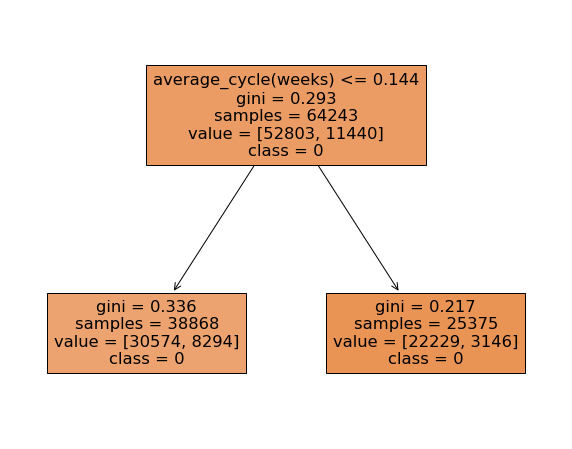

In [19]:
from sklearn import tree
fig = plt.figure(figsize=(10, 8))
_ = tree.plot_tree(clf.best_estimator_, 
                   feature_names = np.array(features.columns),  
                   class_names=["0", "1"],
                   filled=True)

# III. Support Vector Machine Model

### Training the SVM model on the Training set

In [25]:
from sklearn.svm import SVC
cl_svm = SVC(kernel='linear', random_state=0)
cl_svm.fit(X_train_feat, y_train)

SVC(kernel='linear', random_state=0)

### Predicting the test set result

In [26]:
y_pred_svm = cl_svm.predict(X_test_feat)

### Making confusion matrix and calculating accuracy score

In [27]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print('Confusion matrix:')
print(cm_svm)

ac_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy score: {ac_svm}")

preci_svm = precision_score(y_test, y_pred_svm, average = None)
print(f"Precision score: {preci_svm}")

recall_svm = recall_score(y_test, y_pred_svm, average = None)
print(f"Recall score: {recall_svm}")

f1_sc_svm = f1_score(y_test, y_pred_svm, average = None)
print(f"f1 score: {f1_sc_svm}")

Confusion matrix:
[[22619     0]
 [ 4915     0]]
Accuracy score: 0.8214934263092903
Precision score: [0.82149343 0.        ]
Recall score: [1. 0.]
f1 score: [0.90199988 0.        ]


C:\Users\dream\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Applying binaryScore() function to calculate the score of the model

In [28]:
score_svm = binaryScore(y_test, pd.Series(y_pred_svm), normalize= True)
score_svm

0.7541803510994782

##### --> **Comparing the score between decision tree model and SVM_model gives us an inside that the score of SVM model is higher than that of decision tree model. Although, SVM_model predicted only 0_classifier correctly**

# IV. Logistic Regression Model

### Training model on the training set

In [29]:
from sklearn.linear_model import LogisticRegression
cl_reg = LogisticRegression(random_state = 0)
cl_reg.fit(X_train_feat, y_train)

LogisticRegression(random_state=0)

### Predicting the test set result

In [30]:
y_pred_reg = cl_reg.predict(X_test_feat)

### Making confusion matrix and evaluating scores

In [31]:
cm_reg = confusion_matrix(y_test, y_pred_reg)
print('Confusion matrix:')
print(cm_reg)

ac_reg = accuracy_score(y_test, y_pred_reg)
print(f"Accuracy score: {ac_reg}")

preci_reg = precision_score(y_test, y_pred_reg, average = None)
print(f"Precision score: {preci_reg}")

recall_reg = recall_score(y_test, y_pred_reg, average = None)
print(f"Recall score: {recall_reg}")

f1_sc_reg = f1_score(y_test, y_pred_reg, average = None)
print(f"f1 score: {f1_sc_reg}")

Confusion matrix:
[[22506   113]
 [ 4767   148]]
Accuracy score: 0.8227645819713808
Precision score: [0.82521175 0.56704981]
Recall score: [0.9950042 0.0301119]
f1 score: [0.90218873 0.05718702]


### Applying binaryScore() function to calculate the score of the model

In [32]:
score_reg = binaryScore(y_test, pd.Series(y_pred_reg), normalize= True)
score_reg

0.7578147141690146

# V. K-Nearest Neighbors (KNN) Model

### Training the model on the training set

In [33]:
from sklearn.neighbors import KNeighborsClassifier
cl_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
cl_knn.fit(X_train_feat, y_train)

KNeighborsClassifier()

### Predicting the test set result

In [34]:
y_pred_knn = cl_knn.predict(X_test_feat)

### Making confusion matrix and evaluating scores

In [35]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print('Confusion matrix:')
print(cm_knn)

ac_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy score: {ac_knn}")

preci_knn = precision_score(y_test, y_pred_knn, average = None)
print(f"Precision score: {preci_knn}")

recall_knn = recall_score(y_test, y_pred_knn, average = None)
print(f"Recall score: {recall_knn}")

f1_sc_knn = f1_score(y_test, y_pred_knn, average = None)
print(f"f1 score: {f1_sc_knn}")

Confusion matrix:
[[21299  1320]
 [ 4130   785]]
Accuracy score: 0.8020629040459069
Precision score: [0.83758701 0.37292162]
Recall score: [0.94164198 0.15971516]
f1 score: [0.88657176 0.22364672]


### Applying binaryScore() function to calculate the score of the model

In [36]:
score_knn = binaryScore(y_test, pd.Series(y_pred_knn), normalize= True)
score_knn

0.7494290048847173

# VI. Naive Bayes Model

### Training the model on the training set

In [37]:
from sklearn.naive_bayes import GaussianNB
cl_nb = GaussianNB()
cl_nb.fit(X_train_feat, y_train)

GaussianNB()

### Predicting the test set result

In [38]:
y_pred_nb = cl_nb.predict(X_test_feat)

### Making confusion matrix and evaluating scores

In [39]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
print('Confusion matrix:')
print(cm_nb)

ac_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy score: {ac_nb}")

preci_nb = precision_score(y_test, y_pred_nb, average = None)
print(f"Precision score: {preci_nb}")

recall_nb = recall_score(y_test, y_pred_nb, average = None)
print(f"Recall score: {recall_nb}")

f1_sc_nb = f1_score(y_test, y_pred_nb, average = None)
print(f"f1 score: {f1_sc_nb}")

Confusion matrix:
[[22619     0]
 [ 4915     0]]
Accuracy score: 0.8214934263092903
Precision score: [0.82149343 0.        ]
Recall score: [1. 0.]
f1 score: [0.90199988 0.        ]


C:\Users\dream\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
